paper : https://www.itm-conferences.org/articles/itmconf/pdf/2025/01/itmconf_dai2024_01012.pdf

best model : Deep Neural Network

In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=139e9a5cef99150bbf6c4d91801eafdcab4e2d503114e43b4da50b857a22a567
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
!pip install artemis pyartemis alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
import shap
from alibi.explainers import ALE, plot_ale
from sklearn.model_selection import cross_val_score
import sklearn
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
import numpy as np
from sklearn.preprocessing import LabelEncoder
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

1- Model

In [ ]:
#load the preprocessed dataset
df = pd.read_csv("/content/final_loan_data_leakproof.csv")
df.head()

,int_rate,dti,dti_ratio,term_ 60 months,issue_d_year,home_ownership_RENT,addr_state_MI,sub_grade,addr_state_WA,loan_to_income,acc_open_past_24mths,addr_state_AZ,debt_settlement_flag_Y,grade,issue_d_month,credit_history_years,target
0,15.88,5.89,0.0589,False,2013,True,False,3.3,False,0.128205,7.0,False,False,3,7,13.0,0
1,11.99,21.06,0.2106,False,2014,False,False,2.2,False,0.041860,7.0,False,False,2,3,25.0,0
2,12.87,11.52,0.1152,False,2009,False,False,3.0,False,0.246154,4.0,False,False,3,9,13.0,0
3,12.79,6.03,0.0603,False,2016,False,False,3.0,False,0.188889,8.0,False,False,3,7,19.0,1
4,23.99,22.18,0.2218,False,2016,False,False,5.1,False,0.097596,5.0,False,False,5,8,39.0,0


In [ ]:
#Features & Target
X = df.drop(columns=['target', 'debt_settlement_flag_Y'])
Y = df['target']

In [ ]:
X['term_ 60 months'] = X['term_ 60 months'].astype(int)
X['home_ownership_RENT'] = X['home_ownership_RENT'].astype(int)
X['addr_state_MI'] = X['addr_state_MI'].astype(int)
X['addr_state_WA'] = X['addr_state_WA'].astype(int)
X['addr_state_AZ'] = X['addr_state_AZ'].astype(int)

print(X.dtypes)

int_rate                float64
dti                     float64
dti_ratio               float64
term_ 60 months           int64
issue_d_year              int64
home_ownership_RENT       int64
addr_state_MI             int64
sub_grade               float64
addr_state_WA             int64
loan_to_income          float64
acc_open_past_24mths    float64
addr_state_AZ             int64
grade                     int64
issue_d_month             int64
credit_history_years    float64
dtype: object


In [ ]:
#split the data set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42, stratify = Y)

In [ ]:
#standardizing te features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
#Applying SMOTE to handle imbalance
smote = SMOTE(random_state = 42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
print("Class distribution after SMOTE:\n", pd.Series(y_train_res).value_counts())

Class distribution after SMOTE:
 0    27919
1    27919
Name: target, dtype: int64


In [ ]:
#model
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.6),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#complie the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#train the model
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(x_train, y_train, class_weight={0: 1, 1: 2}, batch_size = 128, epochs = 50, validation_split = 0.2, callbacks = [early_stop], verbose = 1)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6537 - loss: 0.8197 - val_accuracy: 0.7757 - val_loss: 0.5254
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7584 - loss: 0.7268 - val_accuracy: 0.7797 - val_loss: 0.5202
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7680 - loss: 0.7229 - val_accuracy: 0.7904 - val_loss: 0.5130
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7739 - loss: 0.7184 - val_accuracy: 0.7863 - val_loss: 0.5184
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7767 - loss: 0.7083 - val_accuracy: 0.7831 - val_loss: 0.5176
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7735 - loss: 0.7098 - val_accuracy: 0.7857 - val_loss: 0.5199
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7747 - loss: 0.7021 - val_accuracy: 0.7907 - val_loss: 0.5104
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7793 - loss: 0.6980 - val_accuracy: 0.

In [ ]:
#prediction
y_pred_prob = model.predict(x_test).ravel()
threshold = 0.4
results = (y_pred_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, results))

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7017333333333333


In [ ]:
#evaluation report
print("\n Report:\n", classification_report(y_test, results))


 Report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80     11965
           1       0.35      0.56      0.43      3035

    accuracy                           0.70     15000
   macro avg       0.61      0.65      0.61     15000
weighted avg       0.76      0.70      0.72     15000



In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, results)
print(cm)

[[8823 3142]
 [1332 1703]]


#2- Explainability Techniques

In [ ]:
feature_names = X.columns.tolist()
target_names = ['No Default', 'Default']

2.1 - H-Statistic

In [ ]:
random.seed(8)
X_exp = X.sample(n=100, replace=True, random_state=8)
X_exp = pd.DataFrame(X_exp, columns = X.columns)

In [ ]:
h_stat = FriedmanHStatisticMethod()
h_stat.fit(model, X_exp)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━

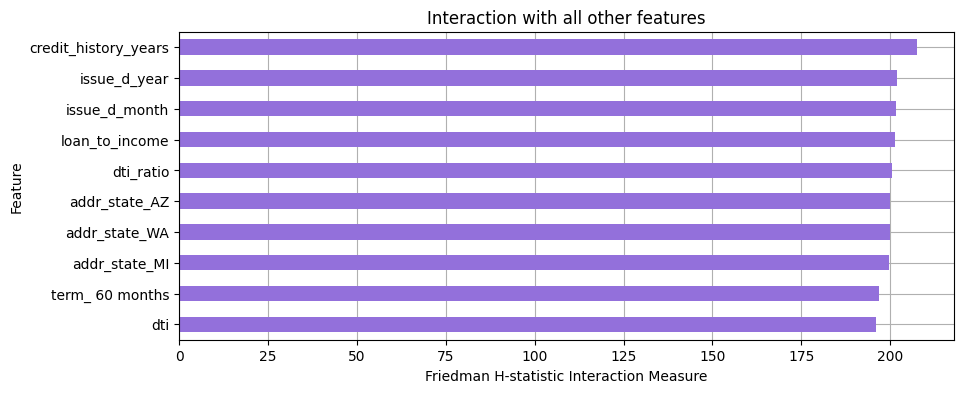

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

In [ ]:
fig.savefig('friedman_h_statistic_DNN_model.png', bbox_inches='tight', dpi=300)

2.2 - Surrogate

In [ ]:
surrogate = DecisionTreeClassifier(max_depth = 3)

In [ ]:
model_pred_train = (model.predict(x_train) >= threshold).astype(int)

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
surrogate.fit(x_train, model_pred_train)

DecisionTreeClassifier(max_depth=3)

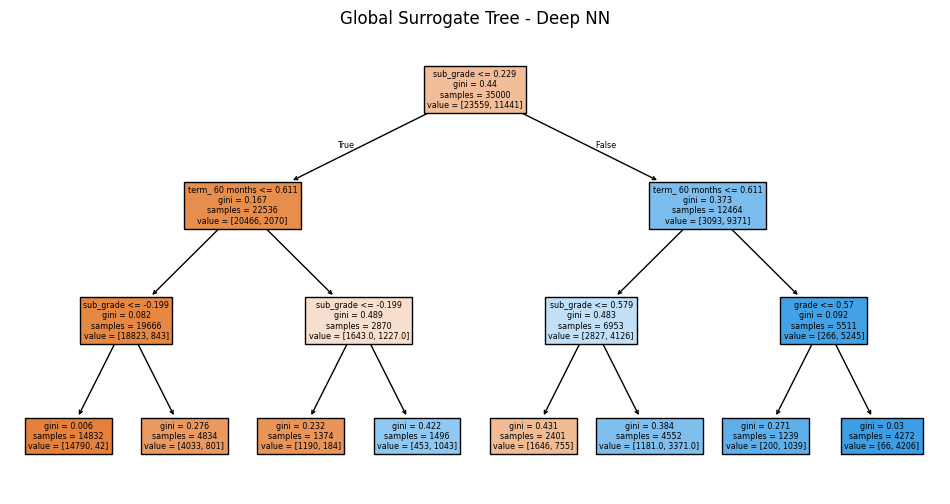

In [ ]:
plt.figure(figsize = (12, 6))
tree.plot_tree(surrogate, feature_names = feature_names, filled = True)
plt.title("Global Surrogate Tree - Deep NN")
plt.savefig('surrogate_tree_DNN_model.png', dpi=300, bbox_inches='tight')
plt.show()

2.3 - Permutation Feature Importance

In [ ]:
def keras_scorer(model, X, y_true):
    y_pred = model.predict(X, verbose=0).round()
    return accuracy_score(y_true, y_pred)

In [ ]:
result = permutation_importance(model, x_test, y_test, n_repeats = 10, random_state = 42, scoring = keras_scorer)

In [ ]:
feature_names = np.array(feature_names)

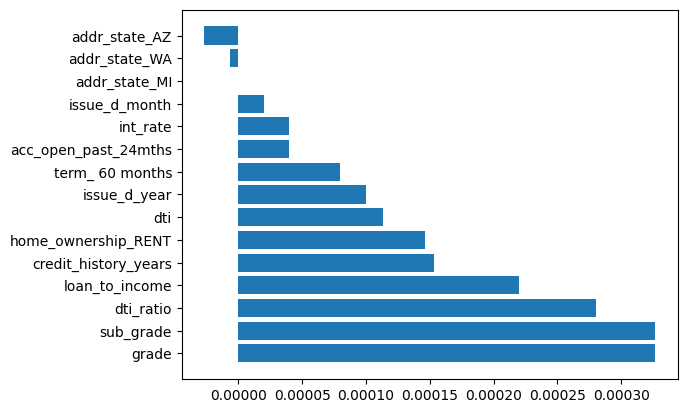

In [ ]:
sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
plt.savefig('permutation_importance_DNN_model.png',
            dpi=300,
            bbox_inches='tight',
            transparent=False)
plt.show()

2.4 - LIME

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = x_train,
    feature_names = feature_names,
    class_names = target_names,
    mode = 'classification'
)

In [ ]:
sample = x_test[10]

exp = explainer.explain_instance(
    sample,
    lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
    num_features=10
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

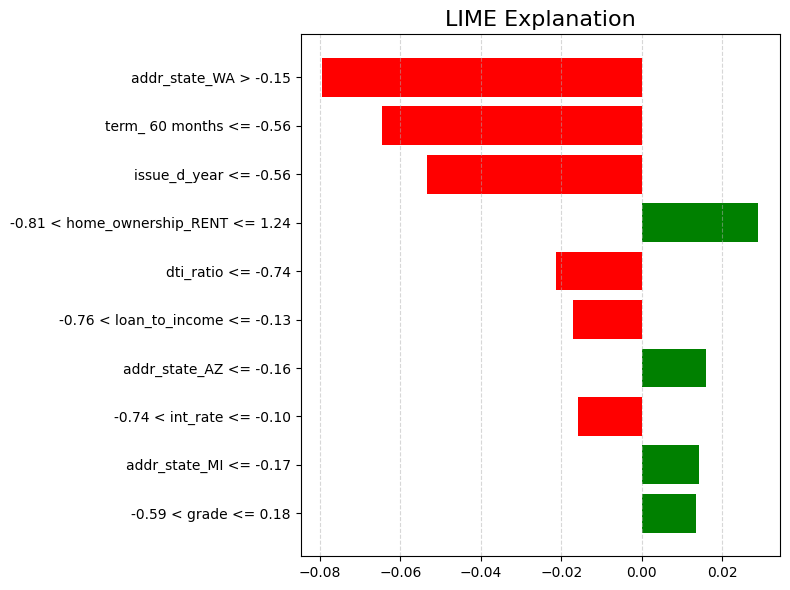

In [ ]:
fig = exp.as_pyplot_figure()
fig.set_size_inches(8, 6)
plt.title("LIME Explanation", fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
fig.savefig("lime_explanation_DNN_model.png", dpi=300, bbox_inches='tight')
plt.show()